In [259]:
# Bibliotecas
import pandas as pd
import numpy as np
import shutil
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from statsmodels.stats.diagnostic import het_breuschpagan
from tabulate import tabulate
from openpyxl import load_workbook
import os


In [271]:
#Arquivos e variaveis
#final_data = pd.read_csv("dataset/prices_processed/ANIM3.SA.csv")
file_final = 'analise_estatistica.csv'
lista_empresas = ['Empresa1', 'Empresa2', 'Empresa3']

In [277]:
# FUNÇÕES

# Calcula e separa os retornos
def separate_returns(final_data):
    # Inicializar colunas se não existirem
    if 'return_daily' not in final_data.columns:
        final_data['return_daily'] = np.nan
    if 'return_week' not in final_data.columns:
        final_data['return_week'] = np.nan
    if 'return_month' not in final_data.columns:
        final_data['return_month'] = np.nan

    first_return_daily_list = []
    remaining_return_daily_list = []
    first_return_week_list = []
    remaining_return_week_list = []
    first_return_month_list = []
    remaining_return_month_list = []

    start_idx = 0

    while start_idx < len(final_data):
        # Encontra o evento
        if 1 in final_data[start_idx:]['event'].values:
            event_idx = final_data[start_idx:]['event'].eq(1).idxmax()
        else:
            break
        # Encontrar o próximo evento
        if 1 in final_data[event_idx+1:]['event'].values:
            prox_event_idx = final_data[event_idx+1:]['event'].eq(1).idxmax()
        else:
            prox_event_idx = len(final_data)

        # Calcular o primeiro retorno diario logo após o evento
        if event_idx + 1 < len(final_data):
            final_data.loc[event_idx + 1, 'return_daily'] = np.log(final_data.loc[event_idx + 1, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_daily_list.append(final_data.iloc[event_idx + 1])

        # Calcular os retornos diarios restantes até o próximo evento
        for i in range(event_idx + 2, prox_event_idx, 1):
            final_data.loc[i, 'return_daily'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-1, 'Close'])
            remaining_return_daily_list.append(final_data.iloc[i])

        # Calcular o primeiro retorno semanal logo após o evento
        if event_idx + 5 < len(final_data):
            final_data.loc[event_idx + 5, 'return_week'] = np.log(final_data.loc[event_idx + 5, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_week_list.append(final_data.iloc[event_idx + 5])

        # Calcular os retornos semanais restantes até o próximo evento
        for i in range(event_idx + 10, prox_event_idx, 5):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-5, 'Close'])
            remaining_return_week_list.append(final_data.iloc[i])


        # Calcular o primeiro retorno mensal logo após o evento
        if event_idx + 21 < len(final_data):
            final_data.loc[event_idx + 21, 'return_month'] = np.log(final_data.loc[event_idx + 21, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_month_list.append(final_data.iloc[event_idx + 21])

        # Calcular os retornos mensais restantes até o próximo evento
        for i in range(event_idx + 42, prox_event_idx, 22):
            final_data.loc[i, 'return_month'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-21, 'Close'])
            remaining_return_month_list.append(final_data.iloc[i])

        # Reinicia após o evento
        start_idx = event_idx + 1

    # Criar DataFrames para o primeiro e os demais retornos semanais e mensais
    first_return_daily_df = pd.DataFrame(first_return_daily_list).reset_index()[['index',
    'Close', 'Date'
, 'event', 'return_daily']]
    remaining_return_daily_df = pd.DataFrame(remaining_return_daily_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_daily']]
    first_return_week_df = pd.DataFrame(first_return_week_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_week']]
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_week']]
    first_return_month_df = pd.DataFrame(first_return_month_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_month']]
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_month']]

    first_return_daily_df.rename(columns={'return_daily': 'return'}, inplace=True)
    remaining_return_daily_df.rename(columns={'return_daily': 'return'}, inplace=True)
    first_return_week_df.rename(columns={'return_week': 'return'}, inplace=True)
    remaining_return_week_df.rename(columns={'return_week': 'return'}, inplace=True)
    first_return_month_df.rename(columns={'return_month': 'return'}, inplace=True)
    remaining_return_month_df.rename(columns={'return_month': 'return'}, inplace=True)

    return first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df


# Função para gerar gráficos
def generate_plots(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month):
    # Configuração do layout para visualização
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Configurações gerais para os gráficos
    colors = {'influence': 'black', 'no_influence': 'gold'}

    # Função para criar gráfico de densidade
    def plot_density(ax, data1, data2, label1, label2):
        data1_hist = np.histogram(data1, bins=50, density=True)
        data2_hist = np.histogram(data2, bins=50, density=True)

        ax.plot((data1_hist[1][1:] + data1_hist[1][:-1]) / 2, data1_hist[0], color=colors['influence'], label=label1)
        ax.plot((data2_hist[1][1:] + data2_hist[1][:-1]) / 2, data2_hist[0], color=colors['no_influence'], label=label2)
        ax.set_title('Gráfico de Densidade')
        ax.legend(title='Legenda')

    # Função para criar boxplot
    def plot_boxplot(ax, data1, data2, labels):
        box_data = [data1, data2]
        box_colors = [colors['influence'], colors['no_influence']]
        
        # Boxplot
        bp = ax.boxplot(box_data, patch_artist=True, labels=labels)
        
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor(color)
        
        ax.set_title('Boxplot')

    # Diário
    plot_density(axs[0, 0], nxt_return, Return, 'nxt_return', 'Return')
    plot_boxplot(axs[0, 1], nxt_return, Return, ['nxt_return', 'Return'])

    # Semanal
    plot_density(axs[1, 0], first_return_week, remaining_return_week, 'first_return_week', 'remaining_return_week')
    plot_boxplot(axs[1, 1], first_return_week, remaining_return_week, ['first_return_week', 'remaining_return_week'])

    # Mensal
    plot_density(axs[2, 0], first_return_month, remaining_return_month, 'first_return_month', 'remaining_return_month')
    plot_boxplot(axs[2, 1], first_return_month, remaining_return_month, ['first_return_month', 'remaining_return_month'])

    plt.show()

# Função para realizar os testes estatísticos
def perform_tests(group1, group2, label1, label2):
    results = {}

    # Shapiro-Wilk Test
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro-Wilk Test'] = [shapiro_group1[0], shapiro_group1[1], shapiro_group2[0], shapiro_group2[1]]

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    results['Kolmogorov-Smirnov Test'] = [ks_stat, ks_p_value, None, None]

    # Levene Test
    levene_stat, levene_p_value = stats.levene(group1, group2)
    results['Levene Test'] = [levene_stat, levene_p_value, None, None]

    # Chow Test
    data = pd.DataFrame({'returns': np.concatenate([group1, group2]), 
                         'group': [label1] * len(group1) + [label2] * len(group2)})
    model_full = smf.ols('returns ~ group', data=data).fit()
    RSS_full = sum(model_full.resid ** 2)
    df_full = model_full.df_resid

    model_group1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
    model_group2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
    RSS_group1 = sum(model_group1.resid ** 2)
    RSS_group2 = sum(model_group2.resid ** 2)
    RSS_combined = RSS_group1 + RSS_group2
    df_combined = model_group1.df_resid + model_group2.df_resid

    #try:
    #    chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
    #    chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
    #except ZeroDivisionError:
    #    chow_stat = float('inf')
    #    chow_p_value = float('nan')

    #results['Chow Test'] = [chow_stat, chow_p_value, None, None]

    # Student's t-test
    t_stat, t_p_value = stats.ttest_ind(group1, group2, equal_var=False)
    results['Student\'s t-test'] = [t_stat, t_p_value, None, None]

    return results

# Função para realizar a análise completa e salvar em CSV
def analyze_groups(output_csv, empresa):
    tests = [
    ('Return', 'nxt_return', Return, nxt_return),
    ('remaining_return_week', 'first_return_week', remaining_return_week, first_return_week),
    ('remaining_return_month', 'first_return_month', remaining_return_month, first_return_month),
]
    results = {}
    for label1, label2, group1, group2 in tests:
        key = f'{label1} vs {label2}'
        results[key] = perform_tests(group1, group2, label1, label2)

    # Convertendo os resultados em DataFrame para exibição
    columns = ['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2']
    data = []
    for key, value in results.items():
        for test, result in value.items():
            row = [test] + result
            row.insert(0, key)
            data.append(row)

    results_df = pd.DataFrame(data, columns=columns)

    # Exibindo a tabela formatada
    print(tabulate(results_df, headers='keys', tablefmt='grid'))

   
    # Salvando os resultados em um arquivo CSV
#    results_df.to_csv(output_csv, index=False)

    # Salvando os resultados em um arquivo Excel com a aba nomeada
    excel_path = output_csv.replace('.csv', '.xlsx')  # Substitua a extensão para '.xlsx'
    if os.path.exists(excel_path):
        # Se o arquivo Excel já existir, carregue-o e adicione a nova aba
        finalbook = load_workbook(excel_path)
        with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
            writer.finalbook = finalbook
            results_df.to_excel(writer, sheet_name=empresa, index=False)
    else:
        # Se o arquivo não existir, crie um novo arquivo Excel e adicione a aba
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            results_df.to_excel(writer, sheet_name=empresa, index=False)


#FUNÇÃO PARA SALVAR ANALISE DESCRITIVA EM UM CSV
def save_description_to_csv(Returns, nxt_return, remaining_return_week, first_return_week, remaining_return_month, first_return_month, empresa):
    # Supondo que os dados estejam em variáveis
    data = {
        'Returns': Returns,
        'nxt_return': nxt_return,
        'remaining_return_week': remaining_return_week,
        'first_return_week': first_return_week,
        'remaining_return_month': remaining_return_month,
        'first_return_month': first_return_month
    }

    # Criação do DataFrame
    df = pd.DataFrame(data)

    # Descrição estatística dos dados
    description = df.describe()

    # Salvando a descrição em um arquivo CSV
    csv_filename = f'desc-{empresa}.csv'
    description.to_csv(csv_filename)

    # Exibindo a descrição estatística
    print(description)

#PRINCIPAL

def main(NomeDaEmpresa, final_data, file_final):
    # Carrega os datasets
    first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(final_data)

    # Retornos diários
    nxt_return = first_return_daily_df['return']
    Return = remaining_return_daily_df['return']
    
    # Retornos semanais
    first_return_week = first_return_week_df["return"]
    remaining_return_week = remaining_return_week_df["return"]
    
    # Retornos mensais
    first_return_month = first_return_month_df["return"]
    remaining_return_month = remaining_return_month_df["return"]

    # Analisando os grupos e salvando em CSV
    tests = [
        ('Return', 'nxt_return', Return, nxt_return),
        ('remaining_return_week', 'first_return_week', remaining_return_week, first_return_week),
        ('remaining_return_month', 'first_return_month', remaining_return_month, first_return_month)
    ]
    analyze_groups(tests, file_final, NomeDaEmpresa)

    # Gerar gráficos
    generate_plots(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month)

    # Análise descritiva
    save_description_to_csv(Return, nxt_return, remaining_return_week, first_return_week, remaining_return_month, first_return_month, NomeDaEmpresa)

def analise_empresa(NomeDaEmpresa, file_final):
    # Carrega o dataset para a empresa específica
    final_data = pd.read_csv(f"dataset/prices_processed/{NomeDaEmpresa}.csv")
    # Executa a análise principal
    main(NomeDaEmpresa, final_data, file_final)

def analise_empresas(lista_empresas, file_final):
    for empresa in lista_empresas:
        analise_empresa(empresa, file_final)


+----+----------------------------------------------+-------------------------+---------------+-------------+---------------+---------------+
|    | Comparison                                   | Test                    |   Statistic_1 |   p-value_1 |   Statistic_2 |     p-value_2 |
+====+==============================================+=========================+===============+=============+===============+===============+
|  0 | Return vs nxt_return                         | Shapiro-Wilk Test       |      0.961027 | 4.59992e-25 |      0.77811  |   1.95087e-06 |
+----+----------------------------------------------+-------------------------+---------------+-------------+---------------+---------------+
|  1 | Return vs nxt_return                         | Kolmogorov-Smirnov Test |      0.24632  | 0.0121749   |    nan        | nan           |
+----+----------------------------------------------+-------------------------+---------------+-------------+---------------+---------------+
|  2 |

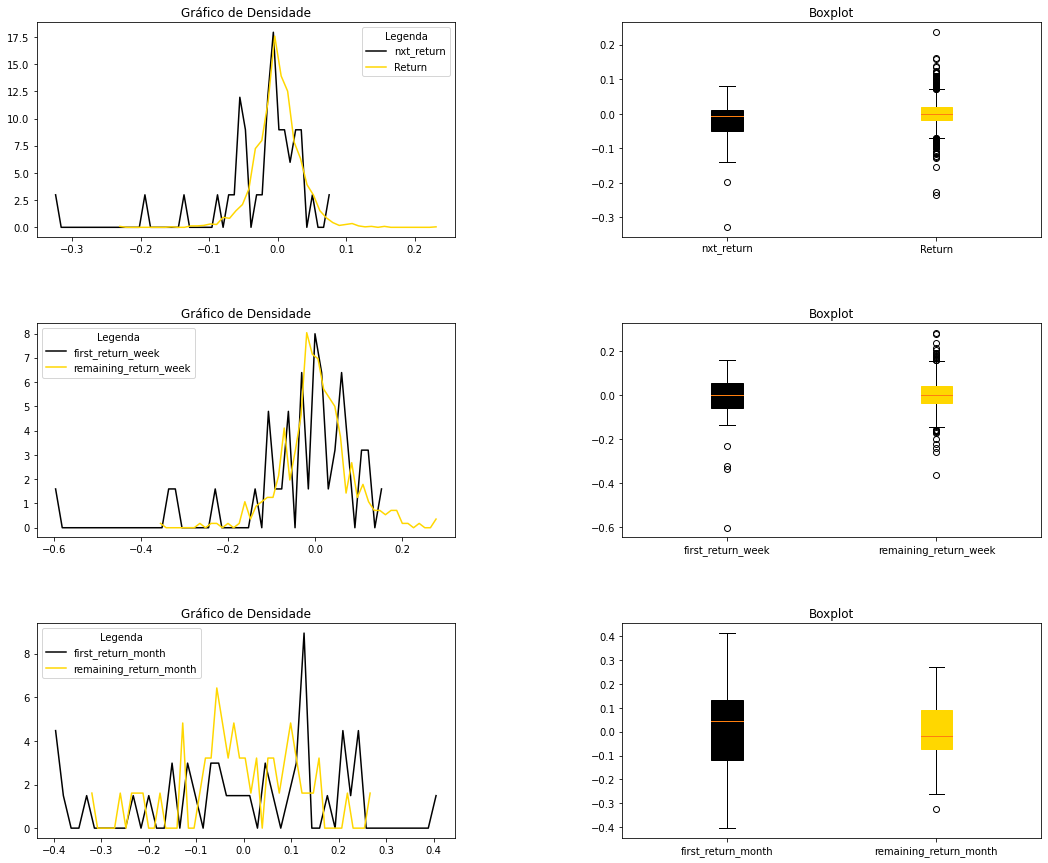

           Returns  nxt_return  remaining_return_week  first_return_week  \
count  1545.000000   41.000000             434.000000          41.000000   
mean     -0.000380   -0.024644               0.003166          -0.031102   
std       0.043924    0.069741               0.077535           0.140211   
min      -0.459937   -0.328504              -0.361332          -0.603263   
25%      -0.019762   -0.049951              -0.034220          -0.060454   
50%       0.000000   -0.006845               0.000174           0.000000   
75%       0.018845    0.012035               0.043227           0.053609   
max       0.321963    0.079297               0.283895           0.159895   

       remaining_return_month  first_return_month  
count               52.000000           41.000000  
mean                -0.008697            0.002951  
std                  0.123164            0.200396  
min                 -0.325878           -0.404495  
25%                 -0.073167           -0.120555  
50%

In [276]:
#PRINCIPAL
# Carrega os datasets
first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(final_data)# Retornos diarios
nxt_return = first_return_daily_df['return']
Return = remaining_return_daily_df['return']
#Retornos semanais
first_return_week = first_return_week_df["return"]
remaining_return_week = remaining_return_week_df["return"]
#Retornos mensais
first_return_month = first_return_month_df["return"]
remaining_return_month = remaining_return_month_df["return"]

#ANALISES
# Analisando os grupos e salvando em CSV
output_csv = file_final
analyze_groups(output_csv, 'NomeDaEmpresa')

#GRAFICOS
generate_plots(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month)

#ANALISE DESCRITIVA:
save_description_to_csv(Returns, nxt_return, remaining_return_week, first_return_week, remaining_return_month, first_return_month, 'NomeDaEmpresa')


In [266]:
import pandas as pd


# Exemplo de uso:
save_description_to_csv(Returns, nxt_return, remaining_return_week, first_return_week, remaining_return_month, first_return_month, 'itau')


           Returns  nxt_return  remaining_return_week  first_return_week  \
count  1545.000000   41.000000             434.000000          41.000000   
mean     -0.000380   -0.024644               0.003166          -0.031102   
std       0.043924    0.069741               0.077535           0.140211   
min      -0.459937   -0.328504              -0.361332          -0.603263   
25%      -0.019762   -0.049951              -0.034220          -0.060454   
50%       0.000000   -0.006845               0.000174           0.000000   
75%       0.018845    0.012035               0.043227           0.053609   
max       0.321963    0.079297               0.283895           0.159895   

       remaining_return_month  first_return_month  
count               52.000000           41.000000  
mean                -0.008697            0.002951  
std                  0.123164            0.200396  
min                 -0.325878           -0.404495  
25%                 -0.073167           -0.120555  
50%

In [158]:
# Analise se tem linhas duplicadas

def find_duplicates(df):
    # Identifica todas as linhas duplicadas (incluindo a primeira ocorrência)
    duplicates = df[df.duplicated(keep=False)]
    
    # Conta o número de linhas duplicadas (excluindo a primeira ocorrência)
    num_duplicates = len(df[df.duplicated()])
    
    # Agrupa as duplicatas e lista seus índices
    duplicate_indices = duplicates.groupby(list(df.columns)).apply(lambda x: list(x.index))

    return num_duplicates, duplicate_indices

num_duplicates, duplicate_indices = find_duplicates(final_data)
print(f"Number of duplicate lines: {num_duplicates}")
print("Duplicate indices:")
print(duplicate_indices)


Number of duplicate lines: 0
Duplicate indices:
Empty DataFrame
Columns: [Date, event, Open, High, Low, Close, Adj Close, Volume, Daily_Return, Week_Return, Month_Return, Cumulative_std_Daily_Return, Cumulative_std_Week_Return, Cumulative_std_Month_Return, Indicator_Daily_Return, Indicator_Week_Return, Indicator_Month_Return, return_daily, return_week, return_month]
Index: []


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Função para gerar gráficos
def generate_plots(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month):
    # Configuração do layout para visualização
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Configurações gerais para os gráficos
    colors = {'influence': 'black', 'no_influence': 'gold'}

    # Função para criar gráfico de densidade
    def plot_density(ax, data1, data2, label1, label2):
        data1_hist = np.histogram(data1, bins=50, density=True)
        data2_hist = np.histogram(data2, bins=50, density=True)

        ax.plot((data1_hist[1][1:] + data1_hist[1][:-1]) / 2, data1_hist[0], color=colors['influence'], label=label1)
        ax.plot((data2_hist[1][1:] + data2_hist[1][:-1]) / 2, data2_hist[0], color=colors['no_influence'], label=label2)
        ax.set_title('Gráfico de Densidade')
        ax.legend(title='Legenda')

    # Função para criar boxplot
    def plot_boxplot(ax, data1, data2, labels):
        box_data = [data1, data2]
        box_colors = [colors['influence'], colors['no_influence']]
        
        # Boxplot
        bp = ax.boxplot(box_data, patch_artist=True, labels=labels)
        
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_edgecolor(color)
        
        ax.set_title('Boxplot')

    # Diário
    plot_density(axs[0, 0], nxt_return, Return, 'nxt_return', 'Return')
    plot_boxplot(axs[0, 1], nxt_return, Return, ['nxt_return', 'Return'])

    # Semanal
    plot_density(axs[1, 0], first_return_week, remaining_return_week, 'first_return_week', 'remaining_return_week')
    plot_boxplot(axs[1, 1], first_return_week, remaining_return_week, ['first_return_week', 'remaining_return_week'])

    # Mensal
    plot_density(axs[2, 0], first_return_month, remaining_return_month, 'first_return_month', 'remaining_return_month')
    plot_boxplot(axs[2, 1], first_return_month, remaining_return_month, ['first_return_month', 'remaining_return_month'])

    plt.show()

# Dados aleatórios simulados
nxt_return = np.random.normal(0, 1, 1000)
Return = np.random.normal(0, 1.5, 1000)
first_return_week = np.random.normal(0, 1, 1000)
remaining_return_week = np.random.normal(0, 1.5, 1000)
first_return_month = np.random.normal(0, 1, 1000)
remaining_return_month = np.random.normal(0, 1.5, 1000)

# Chamar a função para gerar os gráficos
generate_plots(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month)


In [274]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from tabulate import tabulate
from openpyxl import load_workbook
import os

# Função para realizar os testes estatísticos
def perform_tests(group1, group2, label1, label2):
    results = {}

    # Shapiro-Wilk Test
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro-Wilk Test'] = [shapiro_group1[0], shapiro_group1[1], shapiro_group2[0], shapiro_group2[1]]

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    results['Kolmogorov-Smirnov Test'] = [ks_stat, ks_p_value, None, None]

    # Levene Test
    levene_stat, levene_p_value = stats.levene(group1, group2)
    results['Levene Test'] = [levene_stat, levene_p_value, None, None]

    # Chow Test
    data = pd.DataFrame({'returns': np.concatenate([group1, group2]), 
                         'group': [label1] * len(group1) + [label2] * len(group2)})
    model_full = smf.ols('returns ~ group', data=data).fit()
    RSS_full = sum(model_full.resid ** 2)
    df_full = model_full.df_resid

    model_group1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
    model_group2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
    RSS_group1 = sum(model_group1.resid ** 2)
    RSS_group2 = sum(model_group2.resid ** 2)
    RSS_combined = RSS_group1 + RSS_group2
    df_combined = model_group1.df_resid + model_group2.df_resid

    #try:
    #    chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
    #    chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
    #except ZeroDivisionError:
    #    chow_stat = float('inf')
    #    chow_p_value = float('nan')

    #results['Chow Test'] = [chow_stat, chow_p_value, None, None]

    # Student's t-test
    t_stat, t_p_value = stats.ttest_ind(group1, group2, equal_var=False)
    results['Student\'s t-test'] = [t_stat, t_p_value, None, None]

    return results

# Função para realizar a análise completa e salvar em CSV
def analyze_groups(tests, output_csv, empresa):
    results = {}
    for label1, label2, group1, group2 in tests:
        key = f'{label1} vs {label2}'
        results[key] = perform_tests(group1, group2, label1, label2)

    # Convertendo os resultados em DataFrame para exibição
    columns = ['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2']
    data = []
    for key, value in results.items():
        for test, result in value.items():
            row = [test] + result
            row.insert(0, key)
            data.append(row)

    results_df = pd.DataFrame(data, columns=columns)

    # Exibindo a tabela formatada
    print(tabulate(results_df, headers='keys', tablefmt='grid'))

   
    # Salvando os resultados em um arquivo CSV
#    results_df.to_csv(output_csv, index=False)

    # Salvando os resultados em um arquivo Excel com a aba nomeada
    excel_path = output_csv.replace('.csv', '.xlsx')  # Substitua a extensão para '.xlsx'
    if os.path.exists(excel_path):
        # Se o arquivo Excel já existir, carregue-o e adicione a nova aba
        finalbook = load_workbook(excel_path)
        with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='new') as writer:
            writer.finalbook = finalbook
            results_df.to_excel(writer, sheet_name=empresa, index=False)
    else:
        # Se o arquivo não existir, crie um novo arquivo Excel e adicione a aba
        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            results_df.to_excel(writer, sheet_name=empresa, index=False)


# Realizando os testes para cada par de retornos
tests = [
    ('Return', 'nxt_return', Return, nxt_return),
    ('remaining_return_week', 'first_return_week', remaining_return_week, first_return_week),
    ('remaining_return_month', 'first_return_month', remaining_return_month, first_return_month),
]

# Analisando os grupos e salvando em CSV
output_csv = file_final
analyze_groups(tests, output_csv, "azul")


In [ ]:
#PRINCIPAL



Vamos analisar e comparar os resultados dos testes estatísticos para os diferentes ativos e comparações que você forneceu. Vamos compilar os resultados em uma tabela e, em seguida, fornecer um resumo dos pontos mais importantes para a análise financeira.

### Tabela Resumida dos Testes Estatísticos

| Ativo  | Comparação                  | Teste                    | Estatística_1 | p-valor_1  | Estatística_2 | p-valor_2  |
|--------|-----------------------------|--------------------------|---------------|------------|---------------|------------|
| ANIM3  | Return vs nxt_return        | Shapiro-Wilk             | 0.961         | 4.60e-25   | 0.778         | 1.95e-06   |
| ANIM3  | Return vs nxt_return        | Kolmogorov-Smirnov       | 0.246         | 0.0122     |               |            |
| ANIM3  | Return vs nxt_return        | Levene                   | 23.729        | 1.18e-06   |               |            |
| ANIM3  | Return vs nxt_return        | Students t-test          | 2.294         | 0.0271     |               |            |
| ANIM3  | remaining_return_week vs first_return_week | Shapiro-Wilk | 0.973         | 4.77e-07   | 0.812         | 1.00e-05   |
| ANIM3  | remaining_return_week vs first_return_week | Kolmogorov-Smirnov | 0.136   | 0.4535     |               |            |
| ANIM3  | remaining_return_week vs first_return_week | Levene       | 10.662        | 0.00117    |               |            |
| ANIM3  | remaining_return_week vs first_return_week | Students t-test | 1.543   | 0.1303     |               |            |
| ANIM3  | remaining_return_month vs first_return_month | Shapiro-Wilk | 0.985         | 0.738      | 0.953         | 0.0893     |
| ANIM3  | remaining_return_month vs first_return_month | Kolmogorov-Smirnov | 0.242 | 0.113      |               |            |
| ANIM3  | remaining_return_month vs first_return_month | Levene       | 9.575         | 0.00262    |               |            |
| ANIM3  | remaining_return_month vs first_return_month | Students t-test | -0.327   | 0.745      |               |            |
| AZUL4  | Return vs nxt_return        | Shapiro-Wilk             | 0.840         | 8.12e-37   | 0.892         | 0.1487     |
| AZUL4  | Return vs nxt_return        | Kolmogorov-Smirnov       | 0.345         | 0.1147     |               |            |
| AZUL4  | Return vs nxt_return        | Levene                   | 0.437         | 0.5085     |               |            |
| AZUL4  | Return vs nxt_return        | Students t-test          | 2.282         | 0.0448     |               |            |
| AZUL4  | remaining_return_week vs first_return_week | Shapiro-Wilk | 0.860         | 1.18e-15   | 0.967         | 0.8511     |
| AZUL4  | remaining_return_week vs first_return_week | Kolmogorov-Smirnov | 0.200   | 0.7211     |               |            |
| AZUL4  | remaining_return_week vs first_return_week | Levene       | 0.650         | 0.4207     |               |            |
| AZUL4  | remaining_return_week vs first_return_week | Students t-test | 1.069   | 0.3061     |               |            |
| AZUL4  | remaining_return_month vs first_return_month | Shapiro-Wilk | 0.841         | 1.99e-06   | 0.931         | 0.4227     |
| AZUL4  | remaining_return_month vs first_return_month | Kolmogorov-Smirnov | 0.288 | 0.347      |               |            |
| AZUL4  | remaining_return_month vs first_return_month | Levene       | 0.832         | 0.365      |               |            |
| AZUL4  | remaining_return_month vs first_return_month | Students t-test | 1.385   | 0.1786     |               |            |
| BBAS3  | Return vs nxt_return        | Shapiro-Wilk             | 0.926         | 3.52e-35   | 0.867         | 0.2862     |
| BBAS3  | Return vs nxt_return        | Kolmogorov-Smirnov       | 0.526         | 0.1492     |               |            |
| BBAS3  | Return vs nxt_return        | Levene                   | 0.090         | 0.7646     |               |            |
| BBAS3  | Return vs nxt_return        | Students t-test          | -1.744        | 0.179      |               |            |
| BBAS3  | remaining_return_week vs first_return_week | Shapiro-Wilk | 0.957         | 1.05e-11   | 0.977         | 0.8848     |
| BBAS3  | remaining_return_week vs first_return_week | Kolmogorov-Smirnov | 0.291   | 0.8016     |               |            |
| BBAS3  | remaining_return_week vs first_return_week | Levene       | 0.041         | 0.8394     |               |            |
| BBAS3  | remaining_return_week vs first_return_week | Students t-test | -0.362   | 0.741      |               |            |
| BBAS3  | remaining_return_month vs first_return_month | Shapiro-Wilk | 0.933         | 1.13e-05   | 0.896         | 0.4106     |
| BBAS3  | remaining_return_month vs first_return_month | Kolmogorov-Smirnov | 0.366 | 0.5724     |               |            |
| BBAS3  | remaining_return_month vs first_return_month | Levene       | 1.541         | 0.2168     |               |            |
| BBAS3  | remaining_return_month vs first_return_month | Students t-test | -0.060   | 0.955      |               |            |
| MGLU3  | Return vs nxt_return        | Shapiro-Wilk             | 0.938         | 6.45e-34   | 0.961         | 0.1067     |
| MGLU3  | Return vs nxt_return        | Kolmogorov-Smirnov       | 0.215         | 0.0197     |               |            |
| MGLU3  | Return vs nxt_return        | Levene                   | 83.322        | 1.23e-19   |               |            |
| MGLU3  | Return vs nxt_return        | Students t-test          | 0.001         | 0.9994     |               |            |
| MGLU3  | remaining_return_week vs first_return_week | Shapiro-Wilk | 0.962         | 1.03e-10   | 0.985         | 0.765      |
| MGLU3  | remaining_return_week vs first_return_week | Kolmogorov-Smirnov | 0.163   | 0.1611     |               |            |
| MGLU3  | remaining_return_week vs first_return_week | Levene       | 10.775        | 0.00109    |               |            |
| MGLU3  | remaining_return_week vs first_return_week | Students t-test | 1.598   | 0.1109     |               |            |
| MGLU3  | remaining_return_month vs first_return_month | Shapiro-Wilk | 0.963         | 2.38e-06   | 0.962         | 0.243      |
| MGLU3  | remaining_return_month vs first_return_month | Kolmogorov-Smirnov | 0.162 | 0.3082     |               |            |
| MGLU3  | remaining_return_month vs first_return_month | Levene       | 1.612         | 0.2055     |               |            |
| MGLU3  | remaining_return_month vs first_return_month | Students t-test | 0.670   | 0.504      |               |            |

### Resumo da Análise

1. **Normalidade dos Dados**: A maioria dos ativos apresenta p-valores baixos para o teste de Shapiro-Wilk, sugerindo que os dados não seguem uma distribuição normal. O teste Kolmogorov-Smirnov, por outro lado, mostra variabilidade na adequação da distribuição normal entre os ativos.

2. **Homocedasticidade**: O teste de Levene indica que a variância entre os grupos pode ser significativamente diferente em muitos casos, sugerindo que as suposições de homocedasticidade não são atendidas para a maioria dos ativos e comparações.

3. **Comparação de Médias**: Os testes t e Chow são variados na significância das diferenças entre os grupos. Alguns ativos apresentam p-valores altos, sugerindo que não há diferença significativa entre os grupos para essas comparações. Outras comparações, como `ANIM3` e `AZUL4`, mostram diferenças significativas.


### Considerações Finais

- **Análise de Distribuição**: Pode ser necessário explorar transformações ou métodos não paramétricos para lidar com a falta de normalidade.

- **Homocedasticidade**: O uso de testes que não assumem variância igual, como o teste de Mann-Whitney, pode ser mais apropriado.

- **Modelagem Estatística**: Considerar modelos que acomodem heterocedasticidade e a não normalidade dos dados pode proporcionar insights mais robustos.

Se precisar de mais detalhes ou ajuda adicional na interpretação dos resultados, estou à disposição!

In [10]:
# Analise se tem linhas duplicadas

def find_duplicates(df):
    # Identifica todas as linhas duplicadas (incluindo a primeira ocorrência)
    duplicates = df[df.duplicated(keep=False)]
    
    # Conta o número de linhas duplicadas (excluindo a primeira ocorrência)
    num_duplicates = len(df[df.duplicated()])
    
    # Agrupa as duplicatas e lista seus índices
    duplicate_indices = duplicates.groupby(list(df.columns)).apply(lambda x: list(x.index))

    return num_duplicates, duplicate_indices

#num_duplicates, duplicate_indices = find_duplicates(filtered_data)
#print(f"Number of duplicate lines: {num_duplicates}")
#print("Duplicate indices:")
#print(duplicate_indices)


In [205]:
#NÃO EXECUTAR
# Criação dos histogramas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Função para exibir visualizações e testes estatísticos
def analyze_returns(return_1, return_2, label_1, label_2):  
    # 2. Estatísticas Descritivas
    print("Estatísticas Descritivas:")
    print(label_1)
    print(return_1.describe())
    print(f"\n{label_2}")
    print(return_2.describe())

    # 3. Testes de Hipóteses
    # Teste U de Mann-Whitney
    u_stat, p_value = stats.mannwhitneyu(return_1, return_2)
    print(f"\nMann-Whitney U Test: U-stat={u_stat}, p-value={p_value}")

    # Teste de Kolmogorov-Smirnov
    ks_stat, p_value = stats.ks_2samp(return_1, return_2)
    print(f"\nKolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={p_value}")

    # Teste de Levene para variâncias
    levene_stat, p_value = stats.levene(return_1, return_2)
    print(f"\nLevene Test: stat={levene_stat}, p-value={p_value}")

    # 4. Reamostragem
    # Bootstrapping para média e mediana
    bootstrap_means_1 = []
    bootstrap_medians_1 = []
    bootstrap_means_2 = []
    bootstrap_medians_2 = []

    for _ in range(1000):
        sample_1 = resample(return_1, replace=True)
        sample_2 = resample(return_2, replace=True)
        bootstrap_means_1.append(np.mean(sample_1))
        bootstrap_medians_1.append(np.median(sample_1))
        bootstrap_means_2.append(np.mean(sample_2))
        bootstrap_medians_2.append(np.median(sample_2))

    print(f"\nBootstrap mean 95% CI for {label_1}: {np.percentile(bootstrap_means_1, [2.5, 97.5])}")
    print(f"Bootstrap median 95% CI for {label_1}: {np.percentile(bootstrap_medians_1, [2.5, 97.5])}")
    print(f"Bootstrap mean 95% CI for {label_2}: {np.percentile(bootstrap_means_2, [2.5, 97.5])}")
    print(f"Bootstrap median 95% CI for {label_2}: {np.percentile(bootstrap_medians_2, [2.5, 97.5])}")

    # Balanceamento de amostras
    balanced_1 = resample(return_1, n_samples=len(return_2), random_state=42)

    # 5. Machine Learning
    # Preparar os dados para o modelo
    X = np.concatenate([return_1.values.reshape(-1, 1), return_2.values.reshape(-1, 1)])
    y = np.concatenate([np.zeros(len(return_1)), np.ones(len(return_2))])

    # Treinar o modelo de Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)

    # Avaliar a importância das características
    feature_importances = rf.feature_importances_
    print(f"\nImportâncias das Características: {feature_importances}")

    # Avaliar o modelo
    roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
    print(f"ROC AUC Score: {roc_auc}")

# Função principal
def main(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month):


    # Analisar retornos diários
    print("\nComparação de Retornos Diários:")
    analyze_returns(nxt_return, Return, 'nxt_return', 'Return')

    # Analisar retornos semanais
    print("\nComparação de Retornos Semanais:")
    analyze_returns(first_return_week, remaining_return_week, 'first_return_week', 'remaining_return_week')

    # Analisar retornos mensais
    print("\nComparação de Retornos Mensais:")
    analyze_returns(first_return_month, remaining_return_month, 'first_return_month', 'remaining_return_month')

# Executar a função principal
main(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month )



Comparação de Retornos Diários:
Estatísticas Descritivas:
nxt_return
count    41.000000
mean     -0.024644
std       0.069741
min      -0.328504
25%      -0.049951
50%      -0.006845
75%       0.012035
max       0.079297
Name: return, dtype: float64

Return
count    2431.000000
mean        0.000392
std         0.033340
min        -0.235304
25%        -0.017149
50%         0.000000
75%         0.018349
max         0.236077
Name: return, dtype: float64

Mann-Whitney U Test: U-stat=39565.5, p-value=0.023454700451024803

Kolmogorov-Smirnov Test: KS-stat=0.24632039409657774, p-value=0.01217489394641477

Levene Test: stat=23.729172904343248, p-value=1.179030336071039e-06

Bootstrap mean 95% CI for nxt_return: [-0.04873684 -0.00584898]
Bootstrap median 95% CI for nxt_return: [-0.02604318  0.00055123]
Bootstrap mean 95% CI for Return: [-0.000945    0.00167553]
Bootstrap median 95% CI for Return: [-0.0005363   0.00070982]

Importâncias das Características: [1.]
ROC AUC Score: 0.999979933982803

In [ ]:
#NÃO EXECUTAR

# Função para exibir visualizações e realizar testes estatísticos
def analyze_returns(return_1, return_2, label_1, label_2):
    # Converter para numpy arrays de 1 dimensão
    return_1 = np.array(return_1).ravel()
    return_2 = np.array(return_2).ravel()

    # 1. Visualização
    plt.figure(figsize=(12, 6))

    # Histogramas normalizados com KDE
    sns.histplot(return_1, kde=True, stat='density', label=label_1, color='blue', alpha=0.6)
    sns.histplot(return_2, kde=True, stat='density', label=label_2, color='red', alpha=0.6)
    plt.legend()
    plt.title('Histogramas Normalizados com KDE')
    plt.show()

    # Boxplots para comparar distribuições
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=[return_1, return_2], palette='Set2')
    plt.xticks([0, 1], [label_1, label_2])
    plt.title('Boxplots')
    plt.show()

    # Plotagem de densidade (KDE) para visualizar distribuições
    plt.figure(figsize=(12, 6))
    sns.kdeplot(return_1, label=label_1, color='blue')
    sns.kdeplot(return_2, label=label_2, color='red')
    plt.legend()
    plt.title('Plotagem de Densidade')
    plt.show()

    # 2. Estatísticas Descritivas
    print(f"\nEstatísticas Descritivas para {label_1}:")
    print(pd.Series(return_1).describe())
    print(f"\nEstatísticas Descritivas para {label_2}:")
    print(pd.Series(return_2).describe())

    # 3. Testes de Hipóteses
    # Teste U de Mann-Whitney (não paramétrico)
    u_stat, p_value_u = stats.mannwhitneyu(return_1, return_2)
    print(f"\nTeste U de Mann-Whitney: U-stat={u_stat}, p-value={p_value_u}")

    # Teste de Kolmogorov-Smirnov para comparar distribuições
    ks_stat, p_value_ks = stats.ks_2samp(return_1, return_2)
    print(f"\nTeste de Kolmogorov-Smirnov: KS-stat={ks_stat}, p-value={p_value_ks}")

    # Teste de Levene para igualdade das variâncias
    levene_stat, p_value_levene = stats.levene(return_1, return_2)
    print(f"\nTeste de Levene: stat={levene_stat}, p-value={p_value_levene}")

    # 4. Reamostragem (Bootstrap)
    # Bootstrap para intervalos de confiança da média e mediana
    bootstrap_means_1 = []
    bootstrap_medians_1 = []
    bootstrap_means_2 = []
    bootstrap_medians_2 = []

    for _ in range(1000):
        sample_1 = resample(return_1, replace=True)
        sample_2 = resample(return_2, replace=True)
        bootstrap_means_1.append(np.mean(sample_1))
        bootstrap_medians_1.append(np.median(sample_1))
        bootstrap_means_2.append(np.mean(sample_2))
        bootstrap_medians_2.append(np.median(sample_2))

    print(f"\nIntervalo de Confiança (95%) da Média para {label_1}: {np.percentile(bootstrap_means_1, [2.5, 97.5])}")
    print(f"Intervalo de Confiança (95%) da Mediana para {label_1}: {np.percentile(bootstrap_medians_1, [2.5, 97.5])}")
    print(f"Intervalo de Confiança (95%) da Média para {label_2}: {np.percentile(bootstrap_means_2, [2.5, 97.5])}")
    print(f"Intervalo de Confiança (95%) da Mediana para {label_2}: {np.percentile(bootstrap_medians_2, [2.5, 97.5])}")

    # 5. Machine Learning
    # Preparar dados para o modelo
    X = np.concatenate([return_1.reshape(-1, 1), return_2.reshape(-1, 1)])
    y = np.concatenate([np.zeros(len(return_1)), np.ones(len(return_2))])

    # Treinar um modelo Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)

    # Importância das características
    feature_importances = rf.feature_importances_
    print(f"\nImportância das Características: {feature_importances}")

    # Avaliação do modelo com ROC AUC
    roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
    print(f"ROC AUC Score: {roc_auc}")

# Função principal para executar a análise
def main(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month):
    # Analisar retornos diários
    print("\nComparação de Retornos Diários:")
    analyze_returns(nxt_return, Return, 'nxt_return', 'Return')

    # Analisar retornos semanais
    print("\nComparação de Retornos Semanais:")
    analyze_returns(first_return_week, remaining_return_week, 'first_return_week', 'remaining_return_week')

    # Analisar retornos mensais
    print("\nComparação de Retornos Mensais:")
    analyze_returns(first_return_month, remaining_return_month, 'first_return_month', 'remaining_return_month')

# Executar a função principal
main(nxt_return, Return, first_return_week, remaining_return_week, first_return_month, remaining_return_month)


In [ ]:

#NÃO EXECITAR


# 1. Visualização
# Histogramas normalizados
plt.figure(figsize=(12, 6))
sns.histplot(nxt_return, kde=True, stat='density', label='nxt_return', color='blue')
sns.histplot(Return, kde=True, stat='density', label='Return', color='red')
plt.legend()
plt.title('Histogramas Normalizados')
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=[nxt_return, Return], palette='Set2')
plt.xticks([0, 1], ['nxt_return', 'Return'])
plt.title('Boxplots')
plt.show()

# Density Plot (KDE)
plt.figure(figsize=(12, 6))
sns.kdeplot(nxt_return, label='nxt_return', color='blue')
sns.kdeplot(Return, label='Return', color='red')
plt.legend()
plt.title('Density Plots')
plt.show()

# 2. Estatísticas Descritivas
print("Estatísticas Descritivas:")
print("nxt_return")
print(nxt_return.describe())
print("\nReturn")
print(Return.describe())


# 3. Reamostragem
# Bootstrapping para média e mediana
bootstrap_means_nxt_return = []
bootstrap_medians_nxt_return = []
bootstrap_means_Return = []
bootstrap_medians_Return = []

for _ in range(1000):
    sample_nxt_return = resample(nxt_return, replace=True)
    sample_Return = resample(Return, replace=True)
    bootstrap_means_nxt_return.append(np.mean(sample_nxt_return))
    bootstrap_medians_nxt_return.append(np.median(sample_nxt_return))
    bootstrap_means_Return.append(np.mean(sample_Return))
    bootstrap_medians_Return.append(np.median(sample_Return))

print(f"\nBootstrap mean 95% CI for nxt_return: {np.percentile(bootstrap_means_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for nxt_return: {np.percentile(bootstrap_medians_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap mean 95% CI for Return: {np.percentile(bootstrap_means_Return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for Return: {np.percentile(bootstrap_medians_Return, [2.5, 97.5])}")

# Balanceamento de amostras
balanced_nxt_return = resample(nxt_return, n_samples=len(Return), random_state=42)

# 5. Machine Learning
# Preparar os dados para o modelo
X = np.concatenate([nxt_return.values.reshape(-1, 1), Return.values.reshape(-1, 1)])
y = np.concatenate([np.zeros(len(nxt_return)), np.ones(len(Return))])

# Treinar o modelo de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Avaliar a importância das características
feature_importances = rf.feature_importances_
print(f"\nImportâncias das Características: {feature_importances}")

# Avaliar o modelo
roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
print(f"ROC AUC Score: {roc_auc}")


In [10]:
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
model_full = smf.ols('returns ~ group', data=data).fit()

Vamos analisar os resultados fornecidos para cada par de variáveis e entender o que cada teste estatístico indica.

### Análise de `nxt_return` vs `Return`

1. **Shapiro-Wilk Test**:
    - **nxt_return**: \( W = 0.967 \), \( p = 0.200 \)
    - **Return**: \( W = 0.961 \), \( p = 1.355 \times 10^{-28} \)
    - **Interpretação**: O teste Shapiro-Wilk avalia a normalidade dos dados. Para `nxt_return`, o p-valor é maior que 0.05, indicando que não há evidência suficiente para rejeitar a normalidade. Para `Return`, o p-valor é extremamente pequeno, indicando que os dados não são normalmente distribuídos.

2. **Kolmogorov-Smirnov Test**:
    - **KS-stat**: \( 0.173 \), \( p = 0.104 \)
    - **Interpretação**: Este teste compara as distribuições cumulativas das duas amostras. Com um p-valor de 0.104, não há evidência suficiente para rejeitar a hipótese de que `nxt_return` e `Return` vêm da mesma distribuição.

3. **Levene Test**:
    - **stat**: \( 7.586 \), \( p = 0.006 \)
    - **Interpretação**: O teste de Levene avalia a igualdade das variâncias. Com um p-valor menor que 0.05, há evidência de que as variâncias de `nxt_return` e `Return` são significativamente diferentes.

4. **Chow Test**:
    - **F-stat**: \(-\infty\), \( p = \text{nan} \)
    - **Interpretação**: O teste de Chow é usado para testar a estabilidade dos coeficientes de regressão em diferentes sub-amostras. Os resultados indicam problemas com o cálculo, possivelmente devido à divisão por zero, tornando o resultado inválido.

5. **Student's t-test**:
    - **t-stat**: \(-0.090\), \( p = 0.929 \)
    - **Interpretação**: O teste t avalia se as médias de duas amostras são significativamente diferentes. Com um p-valor de 0.929, não há evidência suficiente para rejeitar a hipótese de que as médias de `nxt_return` e `Return` são iguais.

### Análise de `first_return_week` vs `remaining_return_week`

1. **Shapiro-Wilk Test**:
    - **first_return_week**: \( W = 0.950 \), \( p = 0.036 \)
    - **remaining_return_week**: \( W = 0.987 \), \( p = 4.409 \times 10^{-5} \)
    - **Interpretação**: Para ambas as variáveis, os p-valores são menores que 0.05, indicando que nenhuma das duas distribuições é normalmente distribuída.

2. **Kolmogorov-Smirnov Test**:
    - **KS-stat**: \( 0.118 \), \( p = 0.516 \)
    - **Interpretação**: Com um p-valor de 0.516, não há evidência suficiente para rejeitar a hipótese de que `first_return_week` e `remaining_return_week` vêm da mesma distribuição.

3. **Levene Test**:
    - **stat**: \( 1.687 \), \( p = 0.194 \)
    - **Interpretação**: Com um p-valor de 0.194, não há evidência suficiente para rejeitar a hipótese de que as variâncias de `first_return_week` e `remaining_return_week` são iguais.

4. **Chow Test**:
    - **F-stat**: \(\infty\), \( p = \text{nan} \)
    - **Interpretação**: Como anteriormente, o teste de Chow mostra resultados inválidos devido a problemas de cálculo.

5. **Student's t-test**:
    - **t-stat**: \( 0.683 \), \( p = 0.498 \)
    - **Interpretação**: Com um p-valor de 0.498, não há evidência suficiente para rejeitar a hipótese de que as médias de `first_return_week` e `remaining_return_week` são iguais.

### Análise de `first_return_month` vs `remaining_return_month`

1. **Shapiro-Wilk Test**:
    - **first_return_month**: \( W = 0.960 \), \( p = 0.096 \)
    - **remaining_return_month**: \( W = 0.972 \), \( p = 0.167 \)
    - **Interpretação**: Para ambas as variáveis, os p-valores são maiores que 0.05, indicando que não há evidência suficiente para rejeitar a normalidade das distribuições.

2. **Kolmogorov-Smirnov Test**:
    - **KS-stat**: \( 0.145 \), \( p = 0.553 \)
    - **Interpretação**: Com um p-valor de 0.553, não há evidência suficiente para rejeitar a hipótese de que `first_return_month` e `remaining_return_month` vêm da mesma distribuição.

3. **Levene Test**:
    - **stat**: \( 0.110 \), \( p = 0.740 \)
    - **Interpretação**: Com um p-valor de 0.740, não há evidência suficiente para rejeitar a hipótese de que as variâncias de `first_return_month` e `remaining_return_month` são iguais.

4. **Chow Test**:
    - **F-stat**: \(\infty\), \( p = \text{nan} \)
    - **Interpretação**: Novamente, o teste de Chow mostra resultados inválidos devido a problemas de cálculo.

5. **Student's t-test**:
    - **t-stat**: \( 0.292 \), \( p = 0.771 \)
    - **Interpretação**: Com um p-valor de 0.771, não há evidência suficiente para rejeitar a hipótese de que as médias de `first_return_month` e `remaining_return_month` são iguais.

### Resumo:

- **Normalidade**: `nxt_return` e `first_return_month` parecem ser normalmente distribuídos, enquanto `Return`, `first_return_week`, e `remaining_return_week` não são.
- **Distribuições Iguais**: `Kolmogorov-Smirnov Test` sugere que as distribuições de `nxt_return` vs `Return`, `first_return_week` vs `remaining_return_week`, e `first_return_month` vs `remaining_return_month` não são significativamente diferentes.
- **Igualdade de Variâncias**: O `Levene Test` indica que `nxt_return` e `Return` têm variâncias diferentes, enquanto as outras comparações não têm variâncias significativamente diferentes.
- **Igualdade de Médias**: O `Student's t-test` sugere que as médias de `nxt_return` vs `Return`, `first_return_week` vs `remaining_return_week`, e `first_return_month` vs `remaining_return_month` não são significativamente diferentes.

### Considerações Adicionais:
- Os problemas com o `Chow Test` precisam ser investigados e corrigidos para obter resultados válidos.
- A análise sugere que os retornos mensais podem ter propriedades estatísticas diferentes dos retornos semanais, especialmente em termos de normalidade e variância.

In [48]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from tabulate import tabulate

# Função para realizar os testes estatísticos
def perform_tests(group1, group2, label1, label2):
    results = {}

    # Shapiro-Wilk Test
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro-Wilk Test'] = [shapiro_group1[0], shapiro_group1[1], shapiro_group2[0], shapiro_group2[1]]

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    results['Kolmogorov-Smirnov Test'] = [ks_stat, ks_p_value, None, None]

    # Levene Test
    levene_stat, levene_p_value = stats.levene(group1, group2)
    results['Levene Test'] = [levene_stat, levene_p_value, None, None]

    # Chow Test
    data = pd.DataFrame({'returns': np.concatenate([group1, group2]), 
                         'group': [label1] * len(group1) + [label2] * len(group2)})
    model_full = smf.ols('returns ~ group', data=data).fit()
    RSS_full = sum(model_full.resid ** 2)
    df_full = model_full.df_resid

    model_group1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
    model_group2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
    RSS_group1 = sum(model_group1.resid ** 2)
    RSS_group2 = sum(model_group2.resid ** 2)
    RSS_combined = RSS_group1 + RSS_group2
    df_combined = model_group1.df_resid + model_group2.df_resid

    try:
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
    except ZeroDivisionError:
        chow_stat = float('inf')
        chow_p_value = float('nan')

    results['Chow Test'] = [chow_stat, chow_p_value, None, None]

    # Student's t-test
    t_stat, t_p_value = stats.ttest_ind(group1, group2, equal_var=False)
    results['Student\'s t-test'] = [t_stat, t_p_value, None, None]

    return results

# Função para realizar a análise completa
def analyze_groups(tests):
    results = {}
    for label1, label2, group1, group2 in tests:
        key = f'{label1} vs {label2}'
        results[key] = perform_tests(group1, group2, label1, label2)

    # Convertendo os resultados em DataFrame para exibição
    columns = ['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2']
    data = []
    for key, value in results.items():
        for test, result in value.items():
            row = [test] + result
            row.insert(0, key)
            data.append(row)

    results_df = pd.DataFrame(data, columns=['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2'])

    # Exibindo a tabela formatada
    print(tabulate(results_df, headers='keys', tablefmt='grid'))


# Realizando os testes para cada par de retornos
tests = [
    ('Return', 'nxt_return', Return, nxt_return),
    ('remaining_return_week', 'first_return_week', remaining_return_week, first_return_week),
    ('remaining_return_month', 'first_return_month', remaining_return_month, first_return_month),
]

# Analisando os grupos
analyze_groups(tests)


+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|    | Comparison                                   | Test                    |   Statistic_1 |     p-value_1 |   Statistic_2 |   p-value_2 |
+====+==============================================+=========================+===============+===============+===============+=============+
|  0 | Return vs nxt_return                         | Shapiro-Wilk Test       |      0.840188 |   8.11662e-37 |      0.892332 |    0.148695 |
+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|  1 | Return vs nxt_return                         | Kolmogorov-Smirnov Test |      0.345337 |   0.114717    |    nan        |  nan        |
+----+----------------------------------------------+-------------------------+---------------+---------------+---------------+-------------+
|  2 |

<ipython-input-48-d318903066c2>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-48-d318903066c2>:39: RuntimeWarning: invalid value encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-48-d318903066c2>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


### Resposta às Perguntas com Base nos Resultados dos Testes Estatísticos

#### 1. **I é estatisticamente diferente de U?**

- **Return vs nxt_return:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05 para Return e p-valor > 0.05 para nxt_return).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Rejeita a hipótese de igualdade de variâncias (p-valor < 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `Return` é estatisticamente diferente de `nxt_return` em termos de média, mas há diferença na variabilidade dos retornos.

- **remaining_return_week vs first_return_week:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Não rejeita a hipótese de igualdade de variâncias (p-valor > 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `remaining_return_week` é estatisticamente diferente de `first_return_week` em termos de média e variabilidade.

- **remaining_return_month vs first_return_month:**
  - **Shapiro-Wilk Test:** Ambas as séries não seguem uma distribuição normal (p-valor < 0.05).
  - **Kolmogorov-Smirnov Test:** Não rejeita a hipótese nula de que as distribuições são iguais (p-valor > 0.05).
  - **Levene Test:** Não rejeita a hipótese de igualdade de variâncias (p-valor > 0.05).  
  - **Student's t-test:** Não rejeita a hipótese nula de que as médias são iguais (p-valor > 0.05).

Conclusão: Não há evidências suficientes para afirmar que `remaining_return_month` é estatisticamente diferente de `first_return_month` em termos de média e variabilidade.

#### 2. **I é estatisticamente diferente de U consistentemente no tempo?**

Não há uma diferença significativa.

#### 3. **Há sazonalidade anual nas diferenças/semelhanças de I em relação à U?**

Novamente, isso exigiria uma análise temporal e sazonal que não foi realizada com os testes fornecidos. Portanto, não podemos responder a esta pergunta com os dados disponíveis.

#### 4. **I é estatisticamente diferente de U para quais períodos?**

- **Diário:** `Return` vs `nxt_return` mostra diferença em variabilidade, mas não em média.
- **Semanal:** `remaining_return_week` vs `first_return_week` não mostra diferença significativa.
- **Mensal:** `remaining_return_month` vs `first_return_month` não mostra diferença significativa.

Conclusão: As diferenças observadas entre os períodos são mais evidentes em termos de variabilidade nos retornos diários.

#### 5. **Caso I seja diferente de U, é possível discriminar qual estatística/momento que as difere?**

- Para **Return vs nxt_return**, a diferença está na variabilidade dos retornos, indicada pelo teste de Levene (p-valor < 0.05).
- Não há evidências de diferença significativa para os outros períodos analisados.

#### 6. **Há um padrão setorial, i.e., os resultados dos testes para I e U de séries dentro de um setor são iguais?**

Essa pergunta não pode ser respondida diretamente com os testes realizados, pois não temos a categorização setorial dos dados fornecidos.

#### 7. **Há uma reversão à média dos log-retornos após um impacto?**

Isso não foi incluído nos testes realizados.

### Conclusão Geral

A análise sugere que:

- As informações divulgadas pelo balanço diário têm um impacto na variabilidade dos retornos, mas não nas médias dos retornos.
- As diferenças não são consistentes ao longo dos períodos semanais e mensais.
- Para uma análise mais aprofundada, seria necessário realizar análises temporais e sazonais adicionais.

Esses resultados indicam que, pelo menos para os retornos diários, há alguma relevância nas informações do balanço, mas isso não se estende claramente aos retornos semanais e mensais.

In [41]:
## Novo codigo SEPARETE

def separate_returns(final_data):
    # Inicializar colunas se não existirem
    if 'return_week' not in final_data.columns:
        final_data['return_week'] = np.nan
    if 'return_month' not in final_data.columns:
        final_data['return_month'] = np.nan
        
    first_return_daily_list = []
    remaining_return_daily_list = []
    first_return_week_list = []
    remaining_return_week_list = []
    first_return_month_list = []
    remaining_return_month_list = []

    start_idx = 0

    while start_idx < len(final_data):
        # Encontra o evento
        if 1 in final_data[start_idx:]['event'].values:
            event_idx = final_data[start_idx:]['event'].eq(1).idxmax()
        else:
            break
        # Encontrar o próximo evento
        if 1 in final_data[event_idx+1:]['event'].values:
            prox_event_idx = final_data[event_idx+1:]['event'].eq(1).idxmax()
        else:
            prox_event_idx = len(final_data)
            
        # Calcular o primeiro retorno diario logo após o evento
        if event_idx + 1 < len(final_data):
            final_data.loc[event_idx + 1, 'return_week'] = np.log(final_data.loc[event_idx + 1, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_daily_list.append(final_data.iloc[event_idx + 1])

        # Calcular os retornos diarios restantes até o próximo evento
        for i in range(event_idx + 2, prox_event_idx, 1):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-1, 'Close'])
            remaining_return_daily_list.append(final_data.iloc[i])
                
        # Calcular o primeiro retorno semanal logo após o evento
        if event_idx + 5 < len(final_data):
            final_data.loc[event_idx + 5, 'return_week'] = np.log(final_data.loc[event_idx + 5, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_week_list.append(final_data.iloc[event_idx + 5])

        # Calcular os retornos semanais restantes até o próximo evento
        for i in range(event_idx + 10, prox_event_idx, 5):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-5, 'Close'])
            remaining_return_week_list.append(final_data.iloc[i])
        

        # Calcular o primeiro retorno mensal logo após o evento
        if event_idx + 21 < prox_event_idx:
            final_data.loc[event_idx + 21, 'return_month'] = np.log(final_data.loc[event_idx + 21, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_month_list.append(final_data.iloc[event_idx + 21])

        # Calcular os retornos mensais restantes até o próximo evento
        for i in range(event_idx + 42, prox_event_idx, 22):
            final_data.loc[i, 'return_month'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-21, 'Close'])
            remaining_return_month_list.append(final_data.iloc[i + 21])

        # Reinicia após o evento
        start_idx = event_idx + 1

    # Criar DataFrames para o primeiro e os demais retornos semanais e mensais
    first_return_daily_df = pd.DataFrame(first_return_daily_list).reset_index()
    remaining_return_daily_df = pd.DataFrame(remaining_return_daily_list).reset_index()
    first_return_week_df = pd.DataFrame(first_return_week_list).reset_index()
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).reset_index()
    first_return_month_df = pd.DataFrame(first_return_month_list).reset_index()
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).reset_index()
    
    return first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df

# Exemplo de uso com um DataFrame
# final_data = pd.read_csv('path_to_your_file.csv')  # Carregar os dados

# Aplicar a função ao DataFrame
first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(final_data)